In [1]:
from pathlib import Path
cwd_path = Path.cwd()
# Parameters
# ! Change values
dataset = "CIFAR10" # CIFAR10, CIFAR100, SVHN
v_type = "mingd" # mingd, rand
root_path = str(cwd_path.parent / "files") # ! Path for features parent folder
params_path = str(cwd_path.parent / "src") # ! Path for python code?
split_index = 500

print(cwd_path)

from IPython.display import display, Markdown
v_type2disp = dict(mingd="MinGD", rand="Blind Walk")
display(Markdown(f"# {dataset} - {v_type2disp[v_type]} results"))

/data/weijing/DI-ting_normalization/normalization_notebook


# CIFAR10 - MinGD results

In [2]:
import os, sys
sys.path.insert(0, params_path)

import argparse, time # ! `params` module import removed due to not found
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from importlib import reload
from tqdm.auto import tqdm

import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

import seaborn as sns
import pandas as pd
import os

from scipy.stats import combine_pvalues, ttest_ind_from_stats, ttest_ind
from functools import reduce
from scipy.stats import hmean

In [3]:
# ! Change feature loading implementation
MODEL_DIR_PATH = cwd_path.parent / "files/CIFAR10"

name__path_map = {
    "teacher_model-normalized_data-normalized_load-model-normalized": MODEL_DIR_PATH / "model_teacher_model-normalized_data-normalized_load-model-normalized",
    "independent_model-normalized_data-normalized_load-model-normalized": MODEL_DIR_PATH / "model_independent_model-normalized_data-normalized_load-model-normalized",
    "pre-act-18_model-normalized_data-normalized_load-model-normalized": MODEL_DIR_PATH / "model_pre-act-18_model-normalized_data-normalized_load-model-normalized",

    "teacher_model-normalized_data-unnormalized_load-model-normalized": MODEL_DIR_PATH / "model_teacher_model-normalized_data-unnormalized_load-model-normalized",
    "independent_model-normalized_data-unnormalized_load-model-normalized": MODEL_DIR_PATH / "model_independent_model-normalized_data-unnormalized_load-model-normalized",
    "pre-act-18_model-normalized_data-unnormalized_load-model-normalized": MODEL_DIR_PATH / "model_pre-act-18_model-normalized_data-unnormalized_load-model-normalized",

    "teacher_model-unnormalized_data-normalized_load-model-normalized": MODEL_DIR_PATH / "model_teacher_model-unnormalized_data-normalized_load-model-normalized",
    "independent_model-unnormalized_data-normalized_load-model-normalized": MODEL_DIR_PATH / "model_independent_model-unnormalized_data-normalized_load-model-normalized",
    "pre-act-18_model-unnormalized_data-normalized_load-model-normalized": MODEL_DIR_PATH / "model_pre-act-18_model-unnormalized_data-normalized_load-model-normalized",

    "teacher_model-unnormalized_data-unnormalized_load-model-normalized": MODEL_DIR_PATH / "model_teacher_model-unnormalized_data-unnormalized_load-model-normalized",
    "independent_model-unnormalized_data-unnormalized_load-model-normalized": MODEL_DIR_PATH / "model_independent_model-unnormalized_data-unnormalized_load-model-normalized",
    "pre-act-18_model-unnormalized_data-unnormalized_load-model-normalized": MODEL_DIR_PATH / "model_pre-act-18_model-unnormalized_data-unnormalized_load-model-normalized",

    # "teacher_model-normalized_data-normalized_load-model-unnormalized": MODEL_DIR_PATH / "model_teacher_model-normalized_data-normalized_load-model-unnormalized",
    # "independent_model-normalized_data-normalized_load-model-unnormalized": MODEL_DIR_PATH / "model_independent_model-normalized_data-normalized_load-model-unnormalized",
    # "pre-act-18_model-normalized_data-normalized_load-model-unnormalized": MODEL_DIR_PATH / "model_pre-act-18_model-normalized_data-normalized_load-model-unnormalized",

    # "teacher_model-normalized_data-unnormalized_load-model-unnormalized": MODEL_DIR_PATH / "model_teacher_model-normalized_data-unnormalized_load-model-unnormalized",
    # "independent_model-normalized_data-unnormalized_load-model-unnormalized": MODEL_DIR_PATH / "model_independent_model-normalized_data-unnormalized_load-model-unnormalized",
    # "pre-act-18_model-normalized_data-unnormalized_load-model-unnormalized": MODEL_DIR_PATH / "model_pre-act-18_model-normalized_data-unnormalized_load-model-unnormalized",

    # "teacher_model-unnormalized_data-normalized_load-model-unnormalized": MODEL_DIR_PATH / "model_teacher_model-unnormalized_data-normalized_load-model-unnormalized",
    # "independent_model-unnormalized_data-normalized_load-model-unnormalized": MODEL_DIR_PATH / "model_independent_model-unnormalized_data-normalized_load-model-unnormalized",
    # "pre-act-18_model-unnormalized_data-normalized_load-model-unnormalized": MODEL_DIR_PATH / "model_pre-act-18_model-unnormalized_data-normalized_load-model-unnormalized",

    # "teacher_model-unnormalized_data-unnormalized_load-model-unnormalized": MODEL_DIR_PATH / "model_teacher_model-unnormalized_data-unnormalized_load-model-unnormalized",
    # "independent_model-unnormalized_data-unnormalized_load-model-unnormalized": MODEL_DIR_PATH / "model_independent_model-unnormalized_data-unnormalized_load-model-unnormalized",
    # "pre-act-18_model-unnormalized_data-unnormalized_load-model-unnormalized": MODEL_DIR_PATH / "model_pre-act-18_model-unnormalized_data-unnormalized_load-model-unnormalized",
}


In [4]:
# ! Change hdf output path
hdf_output_parent_dir_path = cwd_path / "hdf"
hdf_output_parent_dir_path.mkdir(exist_ok=True)
hdf_output_path = hdf_output_parent_dir_path / f"2A_{dataset}_{v_type}.h5"

csv_output_parent_dir_path = cwd_path / "csv"
csv_output_parent_dir_path.mkdir(exist_ok=True)
csv_output_path = csv_output_parent_dir_path / f"2A_{dataset}_{v_type}.csv"

In [5]:
if not hdf_output_path.exists(): # ! Change path checking
    total_reps = 40
    max_m = 45
    total_inner_rep = 100

    m_list = [x for x in range(2, max_m, 1)]
    p_values_all_threat_models_dict = {}

    n_pbar = tqdm(names, leave=False)
    for name in n_pbar:
        p_vals_per_rep_no = {}
        r_pbar = tqdm(range(total_reps), leave=False)
        for rep_no in r_pbar:
            p_values_list = []
            for m in m_list:
                p_list = get_p_values(m, outputs_tr[name], outputs_te[name], total_inner_rep)
                try:
                    hm = hmean(p_list)
                except:
                    hm = 1.0
                p_values_list.append(hm)
                pbar.set_description(f"{rep_no: 2d} {name} m={m: 3d}: f{hm: 0.5f}")
            r_pbar.set_description(f"rep_no: {rep_no+1}/{total_reps}")
            p_vals_per_rep_no[rep_no] = p_values_list
        p_values_all_threat_models_dict[name] = p_vals_per_rep_no
        
    df_list = []
    for name, rep_dict in p_values_all_threat_models_dict.items():
        df = pd.DataFrame(rep_dict).reset_index().assign(m=lambda r: r.index+2).drop(["index"], axis=1)
        df_list.append(pd.melt(df,id_vars=["m"], var_name="rep_no", value_name="p_value").assign(threat_model=name))
    results_df = pd.concat(df_list)
    
    results_df.to_hdf(str(hdf_output_path), v_type) # ! Change path
    results_df.convert_dtypes().to_csv(str(csv_output_path)) # ! Add Output csv
    results_df
else:
    results_df = pd.read_hdf(str(hdf_output_path), v_type) # ! Change path

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

In [7]:
rename_dict = {  # ! Change mapping
    "threat_model": "Threat Model",
    "teacher": "Source (CIFAR10 train set) model-normalized_data-unnormalized",
    # "distillation": "Distillation",
    # "extract-label": "Label-Query",
    # "extract-logit": "Logit-Query",
    # "zero-shot": "Zero-Shot Learning",
    # "fine-tune": "Fine-Tuning",
    "teacher_model-normalized_data-normalized_load-model-normalized": "Teacher MODEL-normalized DATA-normalized LOAD-model-normalized",
    "independent_model-normalized_data-normalized_load-model-normalized": "Independent MODEL-normalized DATA-normalized LOAD-model-normalized",
    "pre-act-18_model-normalized_data-normalized_load-model-normalized": "Diff. Arch. MODEL-normalized DATA-normalized LOAD-model-normalized",
    "teacher_model-normalized_data-unnormalized_load-model-normalized": "Teacher MODEL-normalized DATA-unnormalized LOAD-model-normalized",
    "independent_model-normalized_data-unnormalized_load-model-normalized": "Independent MODEL-normalized DATA-unnormalized LOAD-model-normalized",
    "pre-act-18_model-normalized_data-unnormalized_load-model-normalized": "Diff. Arch. MODEL-normalized DATA-unnormalized LOAD-model-normalized",
    "teacher_model-unnormalized_data-normalized_load-model-normalized": "Teacher MODEL-unnormalized DATA-normalized LOAD-model-normalized",
    "independent_model-unnormalized_data-normalized_load-model-normalized": "Independent MODEL-unnormalized DATA-normalized LOAD-model-normalized",
    "pre-act-18_model-unnormalized_data-normalized_load-model-normalized": "Diff. Arch. MODEL-unnormalized DATA-normalized LOAD-model-normalized",
    "teacher_model-unnormalized_data-unnormalized_load-model-normalized": "Teacher MODEL-unnormalized DATA-unnormalized LOAD-model-normalized",
    "independent_model-unnormalized_data-unnormalized_load-model-normalized": "Independent MODEL-unnormalized DATA-unnormalized LOAD-model-normalized",
    "pre-act-18_model-unnormalized_data-unnormalized_load-model-normalized": "Diff. Arch. MODEL-unnormalized DATA-unnormalized LOAD-model-normalized",
    "teacher_model-normalized_data-normalized_load-model-unnormalized": "Teacher MODEL-normalized DATA-normalized LOAD-model-unnormalized",
    "independent_model-normalized_data-normalized_load-model-unnormalized": "Independent MODEL-normalized DATA-normalized LOAD-model-unnormalized",
    "pre-act-18_model-normalized_data-normalized_load-model-unnormalized": "Diff. Arch. MODEL-normalized DATA-normalized LOAD-model-unnormalized",
    "teacher_model-normalized_data-unnormalized_load-model-unnormalized": "Teacher MODEL-normalized DATA-unnormalized LOAD-model-unnormalized",
    "independent_model-normalized_data-unnormalized_load-model-unnormalized": "Independent MODEL-normalized DATA-unnormalized LOAD-model-unnormalized",
    "pre-act-18_model-normalized_data-unnormalized_load-model-unnormalized": "Diff. Arch. MODEL-normalized DATA-unnormalized LOAD-model-unnormalized",
    "teacher_model-unnormalized_data-normalized_load-model-unnormalized": "Teacher MODEL-unnormalized DATA-normalized LOAD-model-unnormalized",
    "independent_model-unnormalized_data-normalized_load-model-unnormalized": "Independent MODEL-unnormalized DATA-normalized LOAD-model-unnormalized",
    "pre-act-18_model-unnormalized_data-normalized_load-model-unnormalized": "Diff. Arch. MODEL-unnormalized DATA-normalized LOAD-model-unnormalized",
    "teacher_model-unnormalized_data-unnormalized_load-model-unnormalized": "Teacher MODEL-unnormalized DATA-unnormalized LOAD-model-unnormalized",
    "independent_model-unnormalized_data-unnormalized_load-model-unnormalized": "Independent MODEL-unnormalized DATA-unnormalized LOAD-model-unnormalized",
    "pre-act-18_model-unnormalized_data-unnormalized_load-model-unnormalized": "Diff. Arch. MODEL-unnormalized DATA-unnormalized LOAD-model-unnormalized",
}


In [8]:
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )

In [9]:
# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

In [10]:
# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE - 5)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('legend',fontsize=20) # using a size in points
plt.rc('legend',fontsize='medium') # using a named size

Text(0, 0.5, 'p-value')

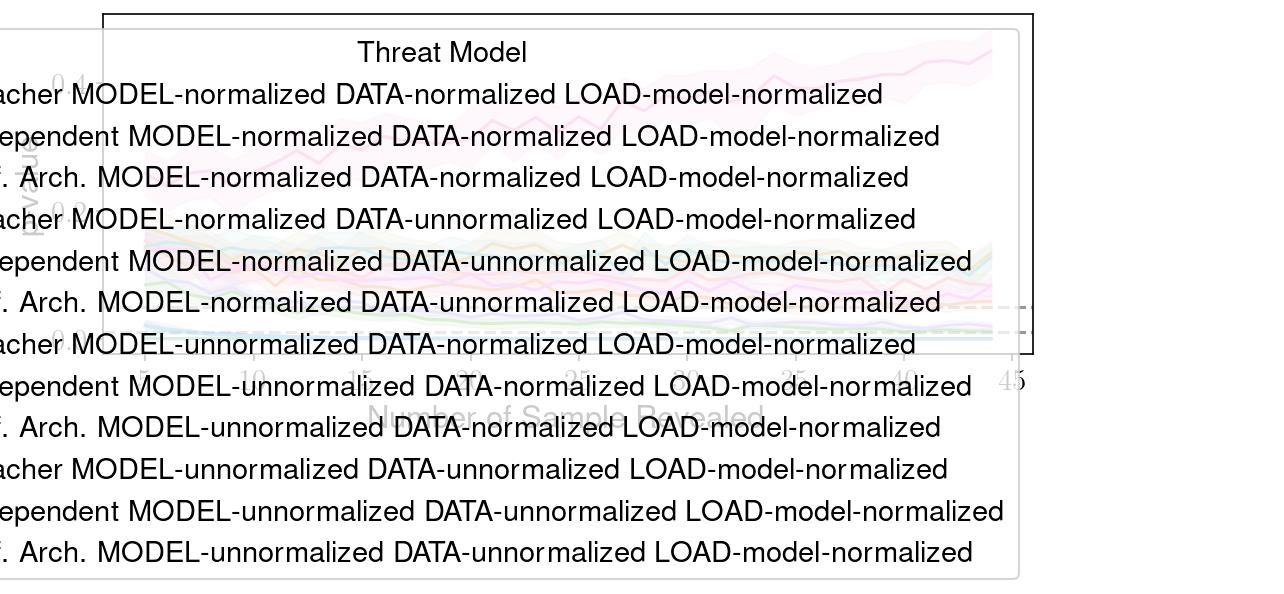

In [11]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")

In [12]:
# fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
# g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
# g.axhline(0.05, ls='--', color="black", alpha=0.4)
# g.axhline(0.01, ls='--', color="black", alpha=0.4)
# g.set_xlabel("Number of Sample Revealed")
# g.set_ylabel("p-value")
# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
# ax.get_legend().remove()

# ! Output graph
# graph_dir_path = cwd_path / "fig"
# graph_dir_path.mkdir(exist_ok=True)
# fig.savefig(
#     fname=graph_dir_path / f"Normalization-2A_CIFAR10_{v_type}.png",
#     transparent=False,
#     bbox_inches="tight",
# )

## Split into diff cases

### 2A

In [13]:
# model-normalized_data-unnormalized only
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )
plot_df = plot_df[
    # (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-normalized LOAD-model-normalized")==True) |
    (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-unnormalized LOAD-model-normalized")==True)
    # (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-normalized LOAD-model-normalized")==True) |
    # (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-unnormalized LOAD-model-normalized")==True)
]

# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

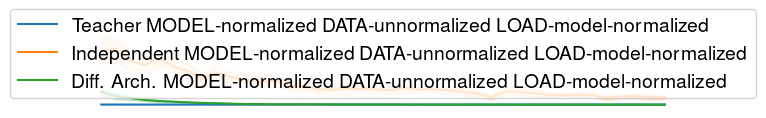

In [14]:
fig, ax = plt.subplots(figsize=(8, 1), dpi=100)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
# g.axhline(0.05, ls='--', color="black", alpha=0.4)
# g.axhline(0.01, ls='--', color="black", alpha=0.4)
# g.set_xlabel("Number of Sample Revealed")
# g.set_ylabel("p-value")
g.set_axis_off()
# Put a legend below current axis
ax.legend(loc='lower center')

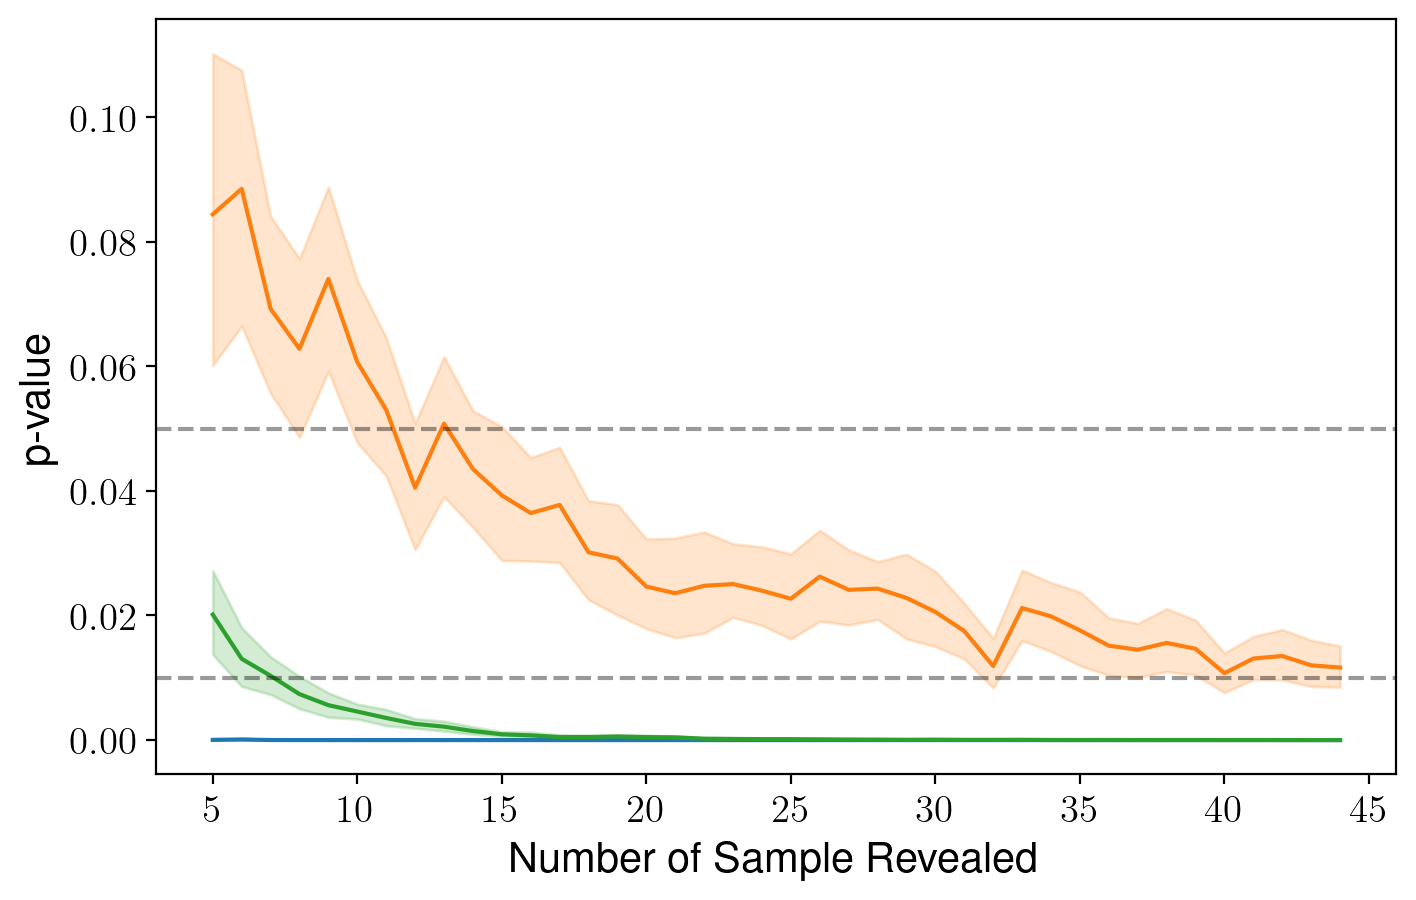

In [15]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99,
palette=[
    'C0',
    'C1',
    'C2',
],
)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
ax.get_legend().remove()

# ! Output graph
# graph_dir_path = cwd_path / "fig"
# graph_dir_path.mkdir(exist_ok=True)
# fig.savefig(
#     fname=graph_dir_path / f"Normalization_CIFAR10_{v_type}.png",
#     transparent=False,
#     bbox_inches="tight",
# )

### 2A vs 1A

In [16]:
# model-normalized_data-unnormalized only
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )
plot_df = plot_df[
    (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-normalized LOAD-model-normalized")==True) |
    (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-unnormalized LOAD-model-normalized")==True)
    # (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-normalized LOAD-model-normalized")==True) |
    # (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-unnormalized LOAD-model-normalized")==True)
]

# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

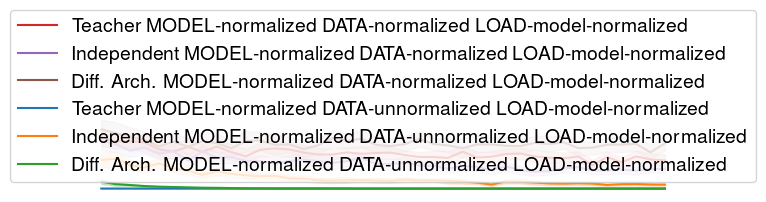

In [17]:
fig, ax = plt.subplots(figsize=(8, 1), dpi=100)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99,
palette=[
    'C3',
    'C4',
    'C5',
    'C0',
    'C1',
    'C2',
],
)
# g.axhline(0.05, ls='--', color="black", alpha=0.4)
# g.axhline(0.01, ls='--', color="black", alpha=0.4)
# g.set_xlabel("Number of Sample Revealed")
# g.set_ylabel("p-value")
g.set_axis_off()
# Put a legend below current axis
ax.legend(loc='lower center')

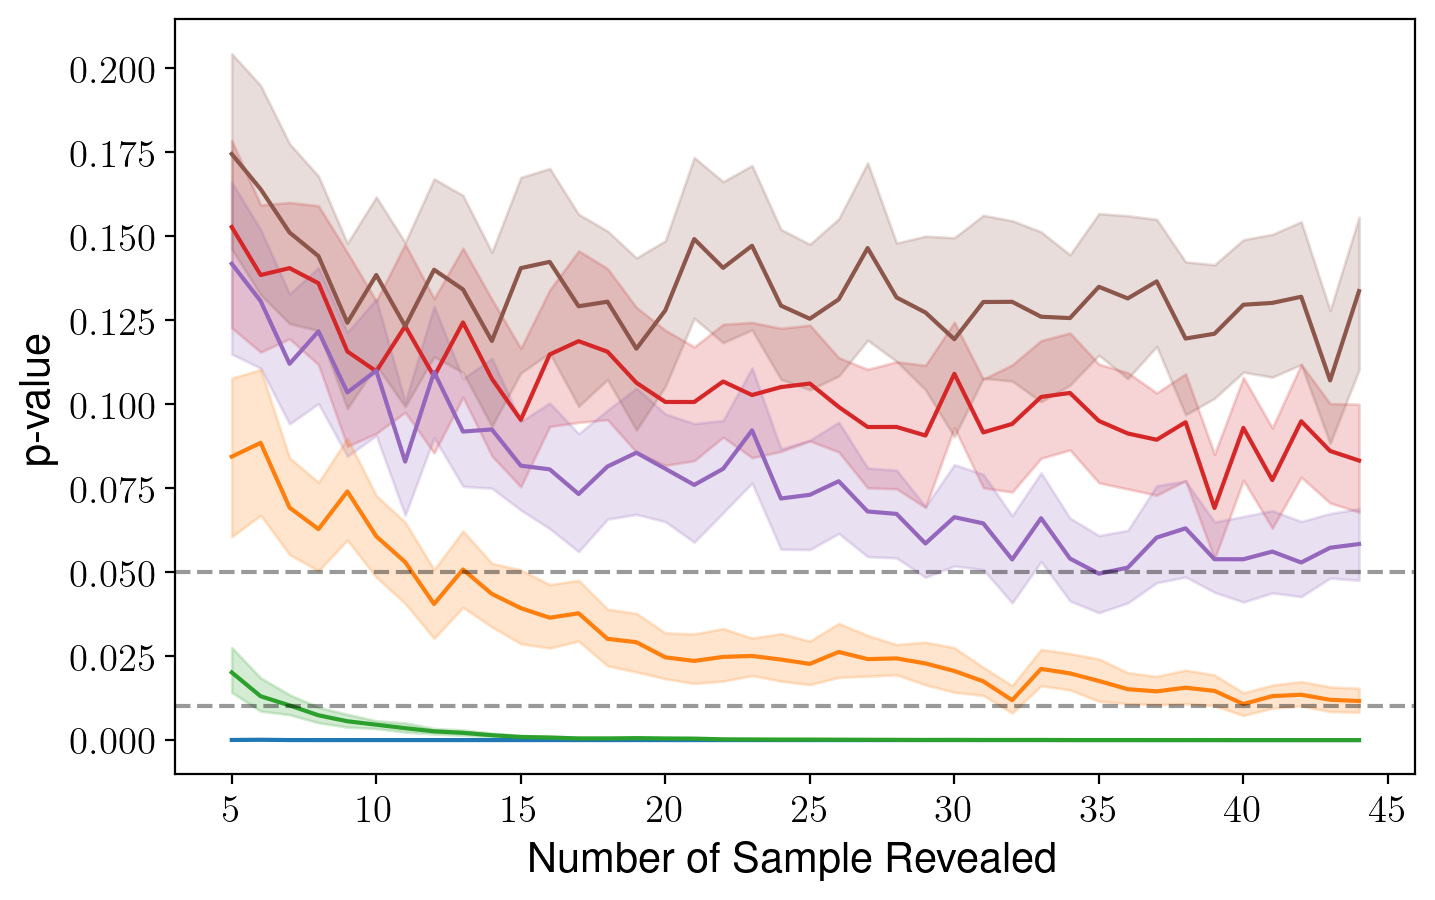

In [18]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99,
palette=[
    'C3',
    'C4',
    'C5',
    'C0',
    'C1',
    'C2',
],
)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
ax.get_legend().remove()

# ! Output graph
# graph_dir_path = cwd_path / "fig"
# graph_dir_path.mkdir(exist_ok=True)
# fig.savefig(
#     fname=graph_dir_path / f"Normalization_CIFAR10_{v_type}.png",
#     transparent=False,
#     bbox_inches="tight",
# )

### 2A vs 3A

In [19]:
# model-normalized_data-unnormalized only
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )
plot_df = plot_df[
    # (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-normalized LOAD-model-normalized")==True) |
    (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-unnormalized LOAD-model-normalized")==True) |
    (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-normalized LOAD-model-normalized")==True)
    # (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-unnormalized LOAD-model-normalized")==True)
]

# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

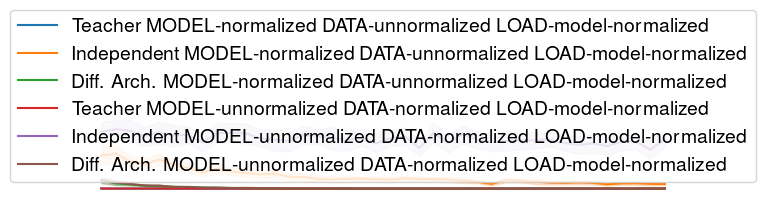

In [20]:
fig, ax = plt.subplots(figsize=(8, 1), dpi=100)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
# g.axhline(0.05, ls='--', color="black", alpha=0.4)
# g.axhline(0.01, ls='--', color="black", alpha=0.4)
# g.set_xlabel("Number of Sample Revealed")
# g.set_ylabel("p-value")
g.set_axis_off()
# Put a legend below current axis
ax.legend(loc='lower center')

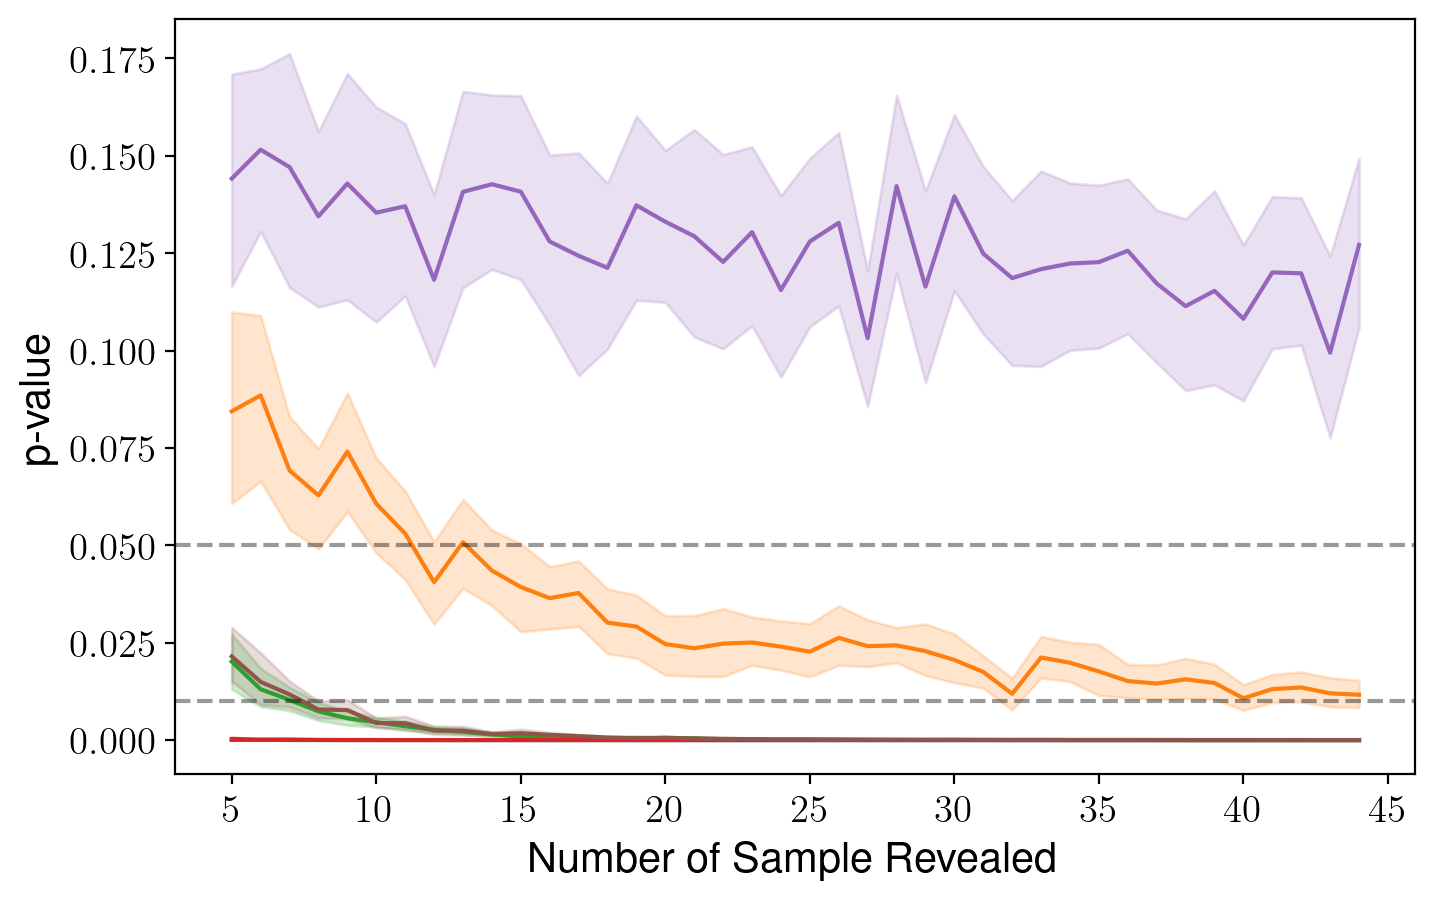

In [21]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
ax.get_legend().remove()

# ! Output graph
# graph_dir_path = cwd_path / "fig"
# graph_dir_path.mkdir(exist_ok=True)
# fig.savefig(
#     fname=graph_dir_path / f"Normalization_CIFAR10_{v_type}.png",
#     transparent=False,
#     bbox_inches="tight",
# )

### 2A vs 4A

In [22]:
# model-normalized_data-unnormalized only
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )
plot_df = plot_df[
    # (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-normalized LOAD-model-normalized")==True) |
    (plot_df["Threat Model"].str.contains("MODEL-normalized DATA-unnormalized LOAD-model-normalized")==True) |
    # (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-normalized LOAD-model-normalized")==True) |
    (plot_df["Threat Model"].str.contains("MODEL-unnormalized DATA-unnormalized LOAD-model-normalized")==True)
]

# ! Fix: ValueError: cannot reindex on an axis with duplicate labels
plot_df[plot_df.index.duplicated()]
plot_df.reset_index(inplace=True)

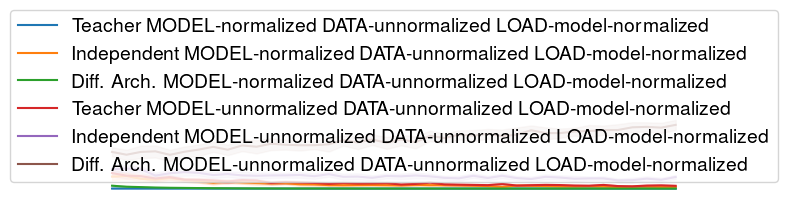

In [23]:
fig, ax = plt.subplots(figsize=(8, 1), dpi=100)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
# g.axhline(0.05, ls='--', color="black", alpha=0.4)
# g.axhline(0.01, ls='--', color="black", alpha=0.4)
# g.set_xlabel("Number of Sample Revealed")
# g.set_ylabel("p-value")
g.set_axis_off()
# Put a legend below current axis
ax.legend(loc='lower center')

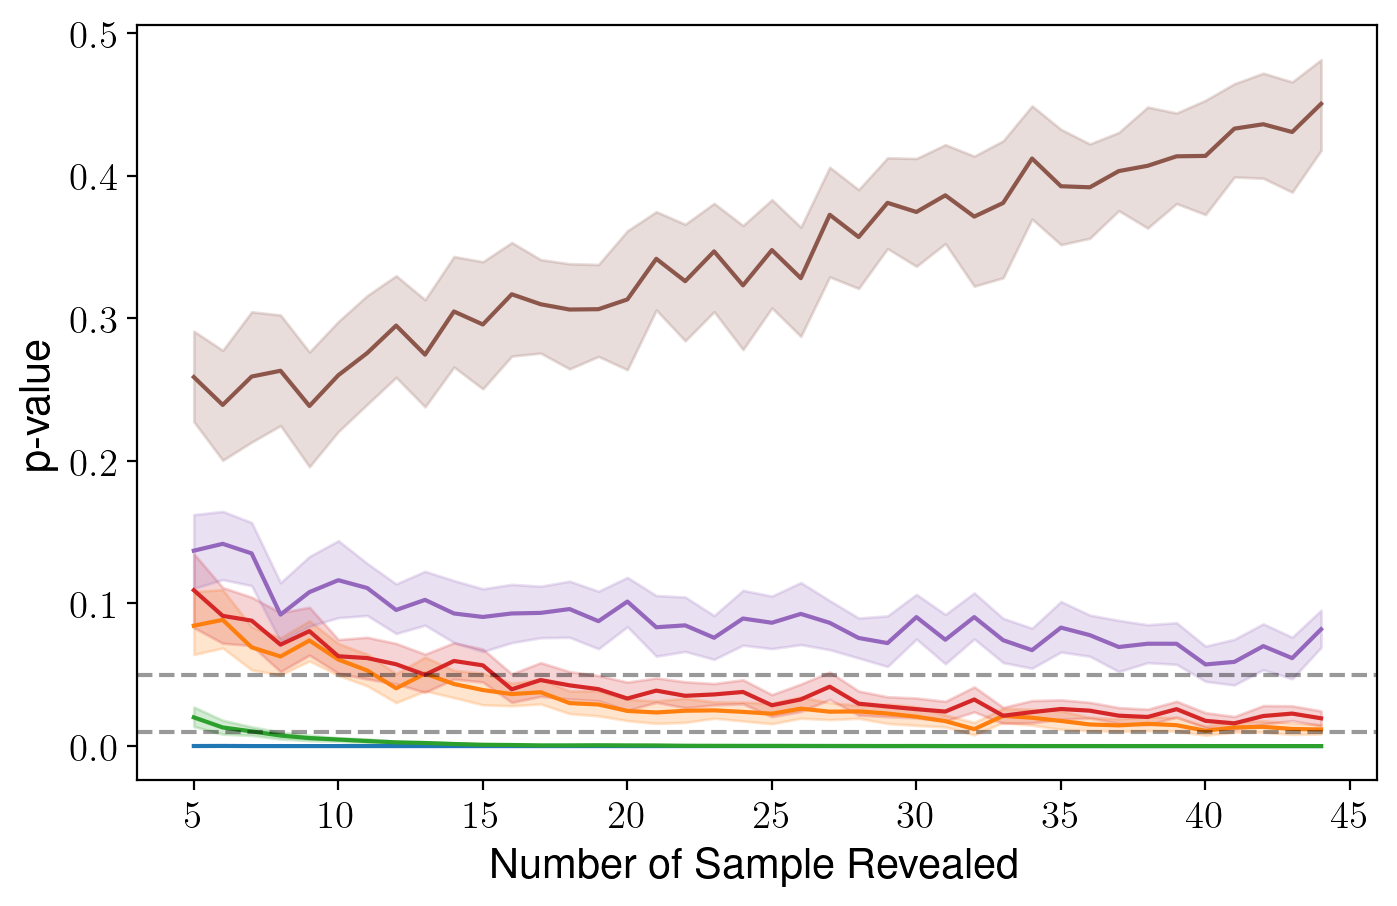

In [24]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=200)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")
# Put a legend below current axis
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=5)
ax.get_legend().remove()

# ! Output graph
# graph_dir_path = cwd_path / "fig"
# graph_dir_path.mkdir(exist_ok=True)
# fig.savefig(
#     fname=graph_dir_path / f"Normalization_CIFAR10_{v_type}.png",
#     transparent=False,
#     bbox_inches="tight",
# )